In [1]:
from typing import TypedDict, Dict, Sequence, List, Annotated, Any
from operator import add
from langgraph.graph import StateGraph, END, START, MessageGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage
from IPython.display import Image
from databricks_langchain import ChatDatabricks

In [2]:
model = ChatDatabricks(endpoint='databricks-mixtral-8x7b-instruct')

In [3]:
class SimpleState(TypedDict):
  a: int
  b: int
  added: int
  subtracted: int


def addition(state: SimpleState) -> Dict[str, int]:
  a = state['a']
  b = state['b']
  added = a + b
  return {"added": added}


def subtraction(state: SimpleState) -> Dict[str, int]:
  a = state['a']
  b = state['b']
  added = state['added']
  # Will return 0
  subtracted = added - a - b
  return {"subtracted": subtracted}


In [4]:
workflow = StateGraph(SimpleState)
workflow.add_node("addition", addition)
workflow.add_node("subtraction", subtraction)

workflow.add_edge(START, "addition")
workflow.add_edge("addition", "subtraction")
workflow.add_edge("subtraction", END)
app = workflow.compile()

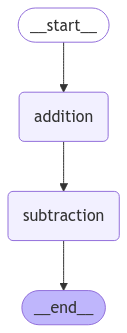

In [5]:
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
input = {"a": 1, "b": 2}

result = app.invoke(input)
type(result)

langgraph.pregel.io.AddableValuesDict

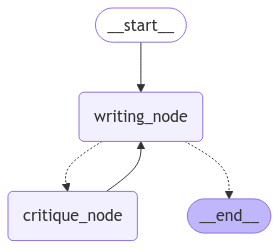

In [7]:
from langgraph.graph.message import add_messages

model = ChatDatabricks(endpoint="databricks-meta-llama-3-1-405b-instruct")
#model = ChatDatabricks(endpoint="databricks-mixtral-8x7b-instruct")

reflection_instruction = """You are a talented poet. Given a poem, provide detailed recommentations no how the poem could be improved. 

Poem:

{poem}
"""


writing_instruction = """You are a talented poet. A user has asked you to write a poem. Write the best poem you can based on the user's request. If the user provides a critique of your writing, revise your poem accordingly. Don't revise the poem unless the user provides feedback. If you receive feedback, return only the revised poem. Don't reference the feedback or thank the user for the feedback."""


critique_prompt = PromptTemplate.from_template(reflection_instruction)
 
writing_prompt = ChatPromptTemplate.from_messages(
  [
    ("system", writing_instruction),
    MessagesPlaceholder(variable_name="messages")
  ]
)


class ReflectionState(TypedDict):
  messages: Annotated[list, add_messages]


def writing_node(state: ReflectionState) -> Dict[str, Any]:

  writing_chain = writing_prompt | model

  poem_generation = writing_chain.invoke({"messages": state['messages']})

  return {"messages": poem_generation}


def critique_node(state: ReflectionState) -> Dict[str, Any]:

  poem = state['messages'][-1].content

  reflection_chain = critique_prompt | model
  critique = reflection_chain.invoke({"poem": poem})

  return {"messages": [HumanMessage(content=critique.content)]}


def continue_critiquing(state: ReflectionState) -> str:
  # Allow for three revisions
  if len(state['messages']) > 7:
    return END
  return "critique_node"


workflow = StateGraph(ReflectionState)
workflow.add_node("writing_node", writing_node)
workflow.add_node("critique_node", critique_node)

workflow.add_edge(START, "writing_node")
workflow.add_conditional_edges("writing_node", continue_critiquing)
workflow.add_edge("critique_node", "writing_node")
app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
response = app.invoke({"messages": 
  [
  HumanMessage(content="Write a poem about a data scientist that loves working on analytical problems")
    ]
  }
)

In [9]:
for resp in response['messages']:
  print(f"{resp.type}: {resp.content}\n\n")

human: Write a poem about a data scientist that loves working on analytical problems


ai: In realms of code, she finds her delight
A world of numbers, her constant light
A data scientist, with passion pure and bright
She dives into the depths, of analytical night

Her mind afire, with questions and with tests
She probes the data, and uncovers hidden bests
Insights emerge, like gems from the earth below
As she applies her craft, with skill and gentle flow

With each new problem, her heart beats fast
A challenge awaits, and she's ready at last
To unravel the threads, of complexity and might
And reveal the answers, in the morning light

In this world of data, she finds her home
Where logic and reason, are her heart's sweet tone
She's a seeker of truth, in every single line
A data scientist, with a passion divine

Her tools are many, her methods refined
From machine learning, to statistical design
She wields them with skill, and a gentle touch
As she coaxes the data, to reveal its hidden 

In [10]:
response

{'messages': [HumanMessage(content='Write a poem about a data scientist that loves working on analytical problems', additional_kwargs={}, response_metadata={}, id='187f63f9-eb36-4f67-9f86-d4fad5d51c06'),
  AIMessage(content="In realms of code, she finds her delight\nA world of numbers, her constant light\nA data scientist, with passion pure and bright\nShe dives into the depths, of analytical night\n\nHer mind afire, with questions and with tests\nShe probes the data, and uncovers hidden bests\nInsights emerge, like gems from the earth below\nAs she applies her craft, with skill and gentle flow\n\nWith each new problem, her heart beats fast\nA challenge awaits, and she's ready at last\nTo unravel the threads, of complexity and might\nAnd reveal the answers, in the morning light\n\nIn this world of data, she finds her home\nWhere logic and reason, are her heart's sweet tone\nShe's a seeker of truth, in every single line\nA data scientist, with a passion divine\n\nHer tools are many, her